
# Week 3 - Discovering higher-level Patterns (Topic Modeling & Clustering)

The first 2 weeks have primarily used the word count of documents as their measure, such as counting the number of "positive" and "negative" words to determine sentiment.

This week, we learn a second kind of document representation in clusters or topics. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
!pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

  Running command git clone --filter=blob:none --quiet https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git 'C:\Users\wimer\AppData\Local\Temp\pip-req-build-5ndtxwfr'


  Cloning https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to c:\users\wimer\appdata\local\temp\pip-req-build-5ndtxwfr
  Resolved https://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian).

In [28]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora?

I'm using a dataset of news articles published digitally in 2019 containing one or more of the words "trans", "transgender", "transsexual", or "transvestite." The dataset itself was created in my hw2 notebook. 

In [42]:
trans_articles = pandas.read_csv('../data/trans_articles_19.csv')
trans_articles.head()

,Unnamed: 0,text,trans,transgender,transsexual,transvestite,only_one,tokens,norm_tokens
0,0,How non-binary teenager Audrey Mason-Hyde i...,False,True,False,True,False,"['How', 'non', 'binary', 'teenager', 'Audrey',...","['non', 'binary', 'teenager', 'audrey', 'mason..."
1,0,Australia's domestic violence crisis1:15 ...,False,True,False,False,True,"['Australia', ""'s"", 'domestic', 'violence', 'c...","['australia', 'domestic', 'violence', 'crisis1..."
2,0,""" Having children has changed our lives mor...",True,True,False,False,False,"['Having', 'children', 'has', 'changed', 'our'...","['have', 'child', 'change', 'life', 'write', '..."
3,0,The grand plans that would have changed Can...,True,False,False,False,True,"['The', 'grand', 'plans', 'that', 'would', 'ha...","['grand', 'plan', 'change', 'canberra', 'know'..."
4,0,The US multinational lobby is losing its vo...,False,True,False,False,True,"['The', 'US', 'multinational', 'lobby', 'is', ...","['multinational', 'lobby', 'lose', 'voice', 'w..."


Given that every document will have one of four words in it, the choice between counts and tf-idf is interesting. tf-idf will _heavily_ penalize some of those words (notably, _trans_ and _transgender_, which are the most frequent), while counting words will overinflate their estimates. 

Due to this, clustering on word counts would move us towards 4 "large" clusters (based on the 4 omnipresent words) which the clustering algorithm may find subclusters of discourse within. tf-idf clustering, however, is likely to reveal clusters within this universe "at large." In other words, the former is an exercise in subdivision, while the latter is an exercise in multiple comparisons.

A "full" analysis would probably want to have both angles, but for the purposes of this script I use WordCount weighting. 

In [63]:
# Limit to 1000 terms, use english stop words, and L2 metric for interpretability.
transArticlesVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_features=1000, stop_words='english', norm='l2')
transVectors = transArticlesVectorizer.fit_transform(trans_articles['text'])
print(transVectors.shape)

(8067, 1000)


In [47]:
list(zip(transArticlesVectorizer.vocabulary_.keys(), transVectors.data))[:20]

[('non', 0.0016266245052020249),
 ('binary', 0.0017870252507431875),
 ('gender', 0.001585280591416988),
 ('identity', 0.0020311293948564687),
 ('time', 0.0018643911926538874),
 ('meet', 0.001674139467183789),
 ('doesn', 0.0015818331512895722),
 ('identify', 0.0015366016580064732),
 ('girl', 0.0021644200535933496),
 ('boy', 0.0018705392429148402),
 ('parents', 0.0017335612928357405),
 ('13', 0.0019988992216089453),
 ('year', 0.0020368093712676894),
 ('old', 0.002289556175809774),
 ('conversation', 0.0015455230899073026),
 ('face', 0.0015031902665152564),
 ('talking', 0.002046673337874794),
 ('needs', 0.0020417210859184944),
 ('women', 0.001772680875485489),
 ('inside', 0.004235733226657045)]

Let's try to calculate silhouette scores in advance so we have a better idea of how many clusters to anticipate.

Notably, the "range(2, 45)" is not entirely computational wastefullness, but the result of weak silhouette scores which striclty increased deep into the 30s.

In [74]:
cluster_measures = pandas.DataFrame({'Clusters':[], 'silhouette_score':[]})
for i in range(2, 45):
    k = sklearn.cluster.KMeans(n_clusters=i, init='k-means++')
    k.fit(transVectors)
    silh = (sklearn.metrics.silhouette_score(transVectors.toarray(), k.labels_))
    cluster_measures = pandas.concat([cluster_measures, pandas.DataFrame({'Clusters':[i], 'silhouette_score':[silh]})])
    

In [75]:
cluster_measures

,Clusters,silhouette_score
0,2.0,0.012130
0,3.0,0.011671
0,4.0,0.011923
0,5.0,0.013480
0,6.0,0.014583
0,7.0,0.014791
0,8.0,0.016364
0,9.0,0.018235
0,10.0,0.020590
0,11.0,0.021764


37 is the first moment our silhouette decreases, 41 is the maximum, and 8 provides a "good enough" clustering. Let's look at those on the silhouette plot.

C:\Users\wimer\AppData\Local\Temp\ipykernel_23916\1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


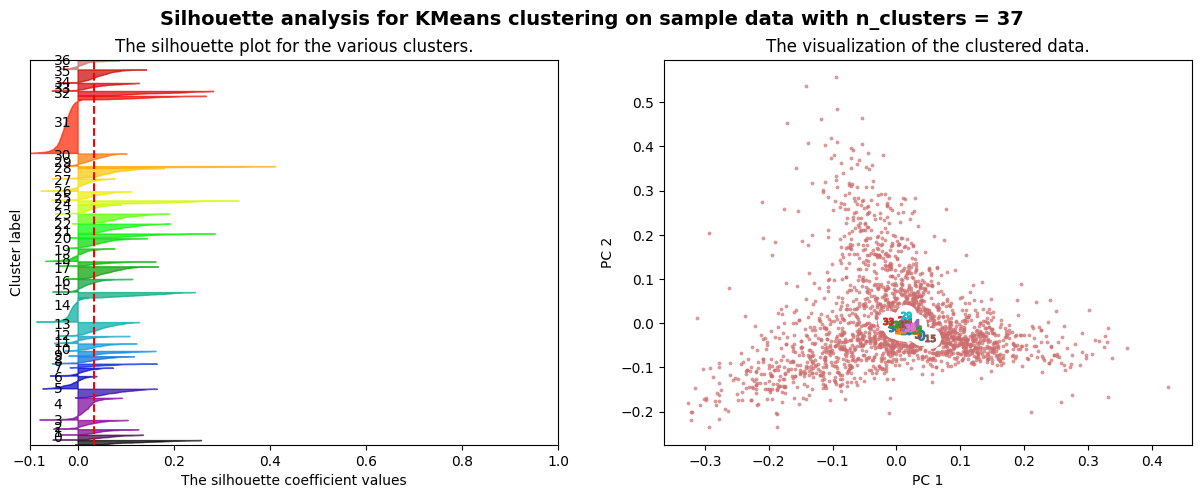

For n_clusters = 37, The average silhouette_score is : 0.033


In [76]:
plotSilhouette(37, transVectors.toarray())

That is.. a unique clustering method. Let's investigate 7 clusters.

C:\Users\wimer\AppData\Local\Temp\ipykernel_23916\1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


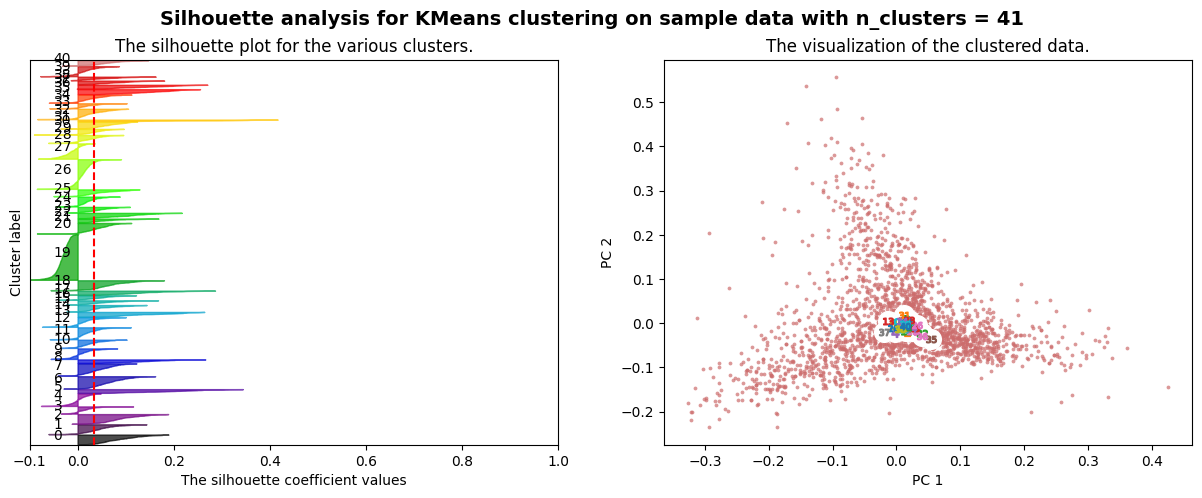

For n_clusters = 41, The average silhouette_score is : 0.035


In [77]:
plotSilhouette(41, transVectors.toarray())

C:\Users\wimer\AppData\Local\Temp\ipykernel_23916\1455843072.py:45: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,


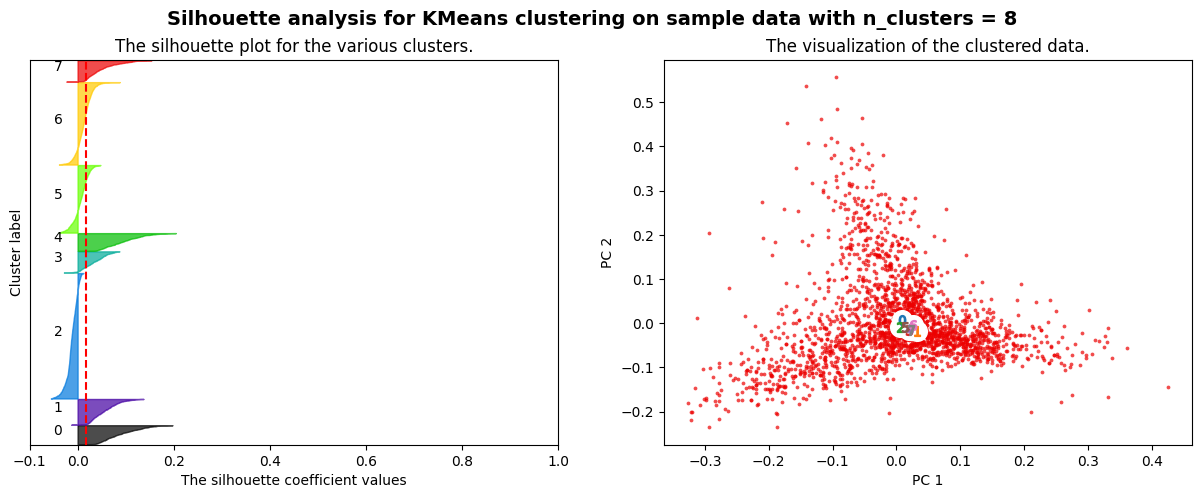

For n_clusters = 8, The average silhouette_score is : 0.017


In [78]:
plotSilhouette(8, transVectors.toarray())

Across all 3 plots, we have a lot of data that does *not* want to cluster well, as evidenced by the preponderence of negative sample silhouette coeffient values throughout. Our clusters also seem like they tend to stay in the middle of the biplot, which is not necessarily a sign of a good clustering.

Let's look at the underlying clusters for each. Due to the large quantity of clusters, this analysis will necessarily be scant.

In [120]:
num_clusters = 37

k = sklearn.cluster.KMeans(n_clusters=num_clusters, init='k-means++')
k = k.fit(transVectors.toarray())

pca = sklearn.decomposition.PCA(n_components=2).fit(transVectors.toarray()) 
pca_data = pca.transform(transVectors.toarray())

In [121]:
clusters = pandas.DataFrame({'kth_best':range(10)})

terms = transArticlesVectorizer.get_feature_names_out()
order_centroids = k.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    best_reps = [terms[j] for j in order_centroids[i, :10]]
    clusters = clusters.merge(
        pandas.DataFrame({'kth_best':range(10), f'cluster {i}':best_reps}),
    on='kth_best')

clusters

,kth_best,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,...,cluster 27,cluster 28,cluster 29,cluster 30,cluster 31,cluster 32,cluster 33,cluster 34,cluster 35,cluster 36
0,0,actor,athletes,comments,trump,pride,like,india,students,rights,...,government,film,music,lgbt,health,court,county,church,sexual,season
1,1,series,sport,said,president,parade,people,indian,university,human,...,said,films,album,gay,care,supreme,road,said,violence,series
2,2,role,women,community,said,community,just,2019,college,transgender,...,minister,festival,song,said,mental,justice,california,god,women,episode
3,3,award,female,comment,house,gay,think,said,student,said,...,party,movie,like,rights,said,said,san,people,rape,netflix
4,4,awards,levels,transgender,democrats,said,really,government,said,persons,...,prime,director,artists,people,medical,transgender,area,christian,said,characters
5,5,movie,sports,people,democratic,rainbow,don,awards,education,discrimination,...,people,story,love,community,patients,military,said,gay,crimes,tv
6,6,trans,male,views,administration,people,know,people,school,people,...,country,actor,new,lesbian,transgender,judge,thursday,gender,hate,new
7,7,film,rules,discussion,military,lgbtq,ve,transgender,gender,government,...,election,character,time,bisexual,people,trump,officials,members,harassment,like
8,8,character,transgender,share,donald,event,says,community,class,pakistan,...,state,international,just,transgender,gender,administration,near,sex,men,cast
9,9,drama,south,attacks,white,city,time,minister,transgender,community,...,pakistan,role,world,march,services,gender,according,lgbtq,report,character


Most of the clusters seen in this table seem reasonable. Cluster 4 seems to capture pride parade articles, cluster 0 seems to collect "award winning trans person" articles, while cluster 1 captures articles about trans people in sports. 

Even though our silhouette is high here, it's not clear that we really need this many clusters. For instance, cluster 28 -- which appears to capture queer film articles -- could probably be grouped with cluster 0. Similarly, cluster 30 could probably be grouped with cluster 4.  

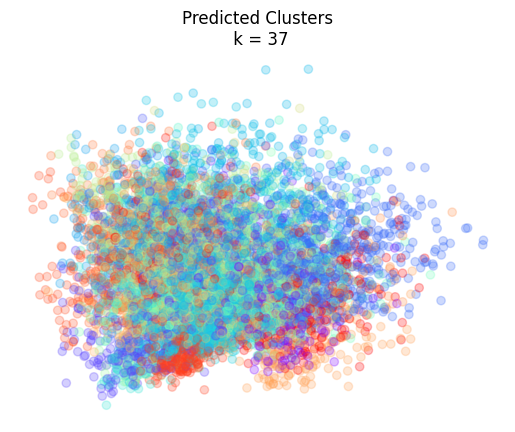

In [122]:
color = list(plt.cm.rainbow(np.linspace(0, 1, num_clusters)))
colors_p = [color[l] for l in k.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(pca_data[:, 0], pca_data[:, 1], color = colors_p, alpha = 0.25, label=colors_p)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_clusters))
plt.show()

This is about what one would expect as a consequence of projecting 37 clusters onto two dimensional space; it's very unclear whether our clusters are at all differentiated, and (at worst) they are certainly not differentiated along our PCA. Let's check the loadings on our pca.

In [133]:
pca.explained_variance_

array([0.01816942, 0.01409463])

That is.. terrible. 

In [123]:
num_clusters = 41

k = sklearn.cluster.KMeans(n_clusters=num_clusters, init='k-means++')
k = k.fit(transVectors.toarray())

pca = sklearn.decomposition.PCA(n_components=2).fit(transVectors.toarray()) 
pca_data = pca.transform(transVectors.toarray())

In [124]:
clusters = pandas.DataFrame({'kth_best':range(10)})

terms = transArticlesVectorizer.get_feature_names_out()
order_centroids = k.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    best_reps = [terms[j] for j in order_centroids[i, :10]]
    clusters = clusters.merge(
        pandas.DataFrame({'kth_best':range(10), f'cluster {i}':best_reps}),
    on='kth_best')

clusters

,kth_best,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8,...,cluster 31,cluster 32,cluster 33,cluster 34,cluster 35,cluster 36,cluster 37,cluster 38,cluster 39,cluster 40
0,0,film,women,court,government,sex,series,party,athletes,lgbtq,...,voters,fashion,hiv,like,march,trump,fat,police,art,gender
1,1,films,men,supreme,said,gay,season,said,sport,community,...,polling,model,aids,people,women,president,food,said,festival,transgender
2,2,festival,gender,justice,minister,marriage,netflix,state,women,gay,...,district,brand,health,just,said,said,disease,woman,artists,people
3,3,movie,trans,said,pakistan,rights,episode,candidates,female,said,...,election,new,said,think,rights,house,health,hate,artist,said
4,4,actor,woman,judge,prime,law,tv,democratic,levels,queer,...,elections,women,people,don,held,administration,heart,transgender,arts,trans
5,5,director,female,case,people,said,drama,election,sports,people,...,commission,company,positive,really,people,donald,risk,victim,work,identity
6,6,story,people,law,country,court,character,candidate,male,discrimination,...,number,transgender,sex,says,police,white,study,death,play,health
7,7,role,said,cases,new,homosexuality,characters,democrats,rules,equality,...,said,york,treatment,know,government,democrats,products,crime,new,birth
8,8,character,violence,transgender,housing,workers,new,campaign,transgender,rights,...,list,instagram,drug,said,saturday,democratic,high,murder,dance,surgery
9,9,life,rights,rights,transgender,sexual,trans,people,south,pride,...,total,year,men,time,violence,republican,blood,year,music,male


41 clusters similarly generates fairly interpretable categories -- cluster 32, which appears to talk about fashion, is a personal favorite -- but it is definitely not clear that we need this many. 

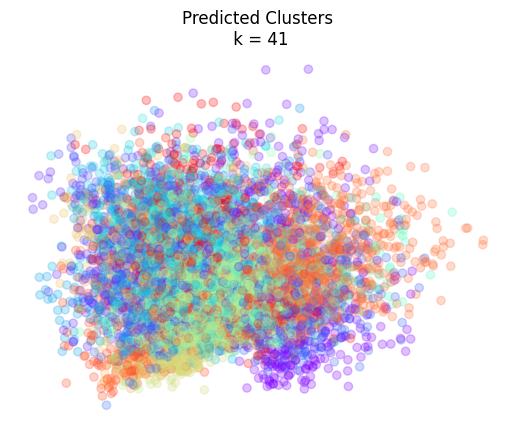

In [125]:
color = list(plt.cm.rainbow(np.linspace(0, 1, num_clusters)))
colors_p = [color[l] for l in k.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(pca_data[:, 0], pca_data[:, 1], color = colors_p, alpha = 0.25, label=colors_p)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_clusters))
plt.show()

In [126]:
num_clusters = 9

k = sklearn.cluster.KMeans(n_clusters=num_clusters, init='k-means++')
k = k.fit(transVectors.toarray())

pca = sklearn.decomposition.PCA(n_components=2).fit(transVectors.toarray()) 
pca_data = pca.transform(transVectors.toarray())


In [127]:
clusters = pandas.DataFrame({'kth_best':range(10)})

terms = transArticlesVectorizer.get_feature_names_out()
order_centroids = k.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    best_reps = [terms[j] for j in order_centroids[i, :10]]
    clusters = clusters.merge(
        pandas.DataFrame({'kth_best':range(10), f'cluster {i}':best_reps}),
    on='kth_best')

clusters

,kth_best,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,cluster 6,cluster 7,cluster 8
0,0,pride,said,health,women,trump,film,like,school,said
1,1,parade,police,hiv,athletes,president,films,people,students,rights
2,2,stonewall,people,fat,men,military,movie,just,schools,lgbt
3,3,lgbtq,transgender,food,female,administration,festival,trans,student,gender
4,4,gay,year,oil,gender,said,actor,says,said,people
5,5,community,new,said,sport,democrats,director,said,education,sex
6,6,people,state,disease,said,house,story,time,gender,gay
7,7,said,2019,study,woman,court,role,new,transgender,transgender
8,8,city,government,people,trans,democratic,character,think,board,community
9,9,rainbow,city,risk,violence,donald,life,really,university,court


9 clusters is much easier to handle. In an attempt to name these (based on above words and limited, off notebook, article skimming):
* Cluster 0: Pride parade articles
* Cluster 1: Trans policing
* Cluster 2: Trans health
* Cluster 3: Trans athletes
* Cluster 4: Nationwide policy about trans people
* Cluster 5: Trans film festival
* Cluster 6: Opinions on trans people
* Cluster 7: Trans kids in schools
* Cluster 8: LGBT rights

Most of these seem fairly self-contained, which is an improvement on the "better" clusters above! 

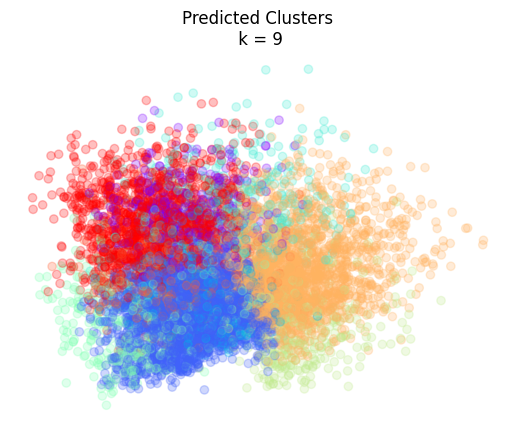

In [128]:
color = list(plt.cm.rainbow(np.linspace(0, 1, num_clusters)))
colors_p = [color[l] for l in k.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(pca_data[:, 0], pca_data[:, 1], color = colors_p, alpha = 0.25, label=colors_p)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(num_clusters))
plt.show()

The plot for these clusters also looks _much_ more intepretable than the prior clusters.

In [ ]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)?

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [ ]:
# random seed chosen by.. keyboard smashing badly.
seed = 10010234

In [151]:
import random as rd
rd.seed(seed)

transCoocMat = transVectors * transVectors.T
transCoocMat.setdiag(0)

# similarly to the examples, we select 1000 articles to look at.
# differently from the examples, we do so randomly.
selectIndices = []
for i in range(1000):
    selectIndices.append(rd.randint(0, len(trans_articles)-1))

subCoocMat = transCoocMat[selectIndices, :][:, selectIndices]

In [152]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

c:\Python311\Lib\site-packages\scipy\cluster\hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[  3., 861.,   0.,   2.],
       [471., 625.,   0.,   2.],
       [ 11., 635.,   0.,   2.],
       [770., 771.,   0.,   2.],
       [286., 418.,   0.,   2.],
       [797., 947.,   0.,   2.],
       [249., 999.,   0.,   2.],
       [178., 284.,   0.,   2.],
       [307., 368.,   0.,   2.],
       [164., 275.,   0.,   2.]])

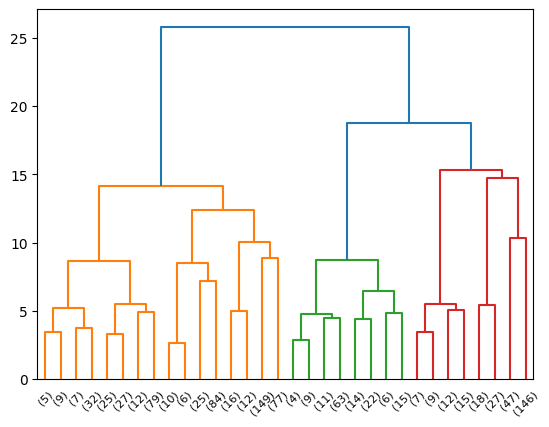

In [153]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

Looking at this plot, we have three "families" that are getting clustered. The first family (on the far left) seems to be the most varied, with a large breadthe of articles within it. The middle branch appears to be relatively distinct from the other two, but also relatively homogenous. 

Let's dig into the three clusters more deeply.

In [159]:
clusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 3, 'maxclust')
silh = sklearn.metrics.silhouette_score(subCoocMat, clusters)
silh

0.09580629570148345

We have a much higher silhouette score for these clusters than we would expect given the k-means performence. As two possible guesses as to why:
* The actual matrix being clustered on (the coocurrence matrix) may be more informative than that clsutered on in the initial algorithm. 
* We are clustering on a sample of our overall dataset (1000 out of approximately 8000 documents). Clustering on the larger dataset is _incredibly_ computationally expensive, taking over 17 minutes to complete, so this limitation will have to exist.

Let's read a few of our documents.

In [199]:
subset_articles = trans_articles.copy().iloc[selectIndices, :]
subset_articles['cluster'] = clusters

In [192]:
for row in subset_articles.loc[subset_articles['cluster'] == 1][:10].get('text'):
    print(row)

   Chelsea Manning memoir coming in winter of 2020   NEW YORK ( AP ) -- Chelsea Manning , the former Army intelligence analyst jailed for leaking government documents , has a book deal .   Farrar , Straus and Giroux announced this week that Manning's memoir , currently untitled , will come out next winter . According to the publisher , Manning , 31 , will write about her childhood and military service , about why she decided to send hundreds of thousands of classified materials to WikiLeaks , and about her life as a trans woman .   Manning was sentenced to 35 years , but was released in May 2017 after President Barack Obama commuted her time in prison . Recently , she was jailed for two months for refusing to answer a grand jury's questions about WikiLeaks founder Julian Assange. 

   Yesterday , we wrote about Jonathan Yaniv , who goes by the name " Jessica , " who took a home salon owner before the Canadian Human Rights Tribunal for refusing to give him a Brazilian Wax . It turns out

In [198]:
for row in subset_articles.loc[subset_articles['cluster'] == 2][:10].get('text'):
    print(row)

   ' A Gateway to Self-Discovery ' : An Interview with Elegance Bratton   Keelyn Bradley : Your film work has been contrasted with Jenni Livingston's Paris Is Burning and praised for its ability to do what many critics have accused Livingston's anthropological approach for failing : authentically framing the subjects of documentary narrating their own stories free from an exploitative colonizing gaze . In Pier Kids : The Life , you tell your story through the Black gay and transgender youth in the film . Marlon Riggs uses this technique similarly to full effect for the first time in Tongues Untied and later in Black Is ... Black Ain't . How has Tongues , if at all , influenced your own work ?   Elegance Bratton : Marlon Riggs is a life influence for me . When I set out to make Pier Kids , I didn't know how to make a film but knew I had something about my life and the life conditions of other queer Black folks who experience family rejection . I was deep in my course work as an African 

In [195]:
for row in subset_articles.loc[subset_articles['cluster'] == 3][:10].get('text'):
    print(row)

   The Perlis mufti said that if transgenderism were recognised , it would allegedly give men an excuse to hurt women .   " If there is a ' mak nyah ' hitting a woman , we must assume it as a man hitting a woman .   " There are only two recognised genders . There is not a third . Religion prohibits this invented gender named ' mak nyah ' or ' saudarai ' , or whatever the name , " he wrote on his Facebook page , using the Malay term for trans women .   " Trans women " or " transgender " are terms used to refer to those who were born male but associate themselves with the female identity , and differ from sex assigned at birth and sexual orientation .   Despite his assertion , violence by men against both women and trans women are more common than by a trans woman against a fellow woman .   On New Year's Day this year , a 39-year-old trans woman was found dead in Klang , allegedly a murder victim .   Last Christmas , four youths aged 21 and below were @ @ @ @ @ @ @ @ @ @ Bandar Bukit Tin

These clusters are.. interesting. Cluster 1 appears to focus primarily on current events, with the articles coincidentally containing trans related information. Cluster 2 seems to focus on celebrities and notable people (trans or otherwise). Cluster 3 seems to be the most queer related cluster, with many of its articles considering trans and queer rights in the news.

Based on this read, the clusters are present, but perhaps not outlandishly useful at this level of conglomeration.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</font>

In [216]:
import ast

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

trans_articles['reduced_tokens'] = trans_articles['norm_tokens']\
    .apply(lambda x: dropMissing(ast.literal_eval(x), transArticlesVectorizer.vocabulary_.keys()))

trans_training = trans_articles.sample(frac=.5)

In [218]:
dictionary = gensim.corpora.Dictionary(trans_training['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in trans_training['reduced_tokens']]
gensim.corpora.MmCorpus.serialize('trans.mm', corpus)
transmm = gensim.corpora.MmCorpus('trans.mm')

In [283]:
eta = np.ones(862)*2
num_topics = 7
translda = gensim.models.ldamodel.LdaModel(corpus = transmm, id2word = dictionary,\
                                           num_topics=num_topics, alpha='auto', eta=eta )

In [284]:
ldaDF = pandas.DataFrame({
    'text':trans_training['text'],
    'topics': [translda[dictionary.doc2bow(l)] for l in trans_training['reduced_tokens']]
})

topicsProbDict = {i : [0] * len(ldaDF) for i in range(translda.num_topics)}

for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

for topicNum in range(translda.num_topics):
    ldaDF[f'topic_{topicNum}'] = topicsProbDict[topicNum]

ldaDF.head()

,text,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6
840,"Interview with Zenith Virago , director and...","[(0, 0.07462735), (2, 0.07003426), (5, 0.23349...",0.074627,0.000000,0.070034,0.000000,0.000000,0.233499,0.619784
1533,After flooding shut down Interstate 5 in Co...,"[(5, 0.9917174)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.991717,0.000000
1200,Acertain kind of book predictably gets desc...,"[(2, 0.44462198), (4, 0.23766062), (5, 0.08418...",0.000000,0.000000,0.444622,0.000000,0.237661,0.084187,0.229721
2642,Why Kenney's Attack on School Gay-Straight ...,"[(0, 0.46229738), (1, 0.29479343), (3, 0.24123...",0.462297,0.294793,0.000000,0.241239,0.000000,0.000000,0.000000
4559,Vicar who resigned as school governor over ...,"[(0, 0.292035), (1, 0.2597673), (3, 0.36650735...",0.292035,0.259767,0.000000,0.366507,0.000000,0.078856,0.000000


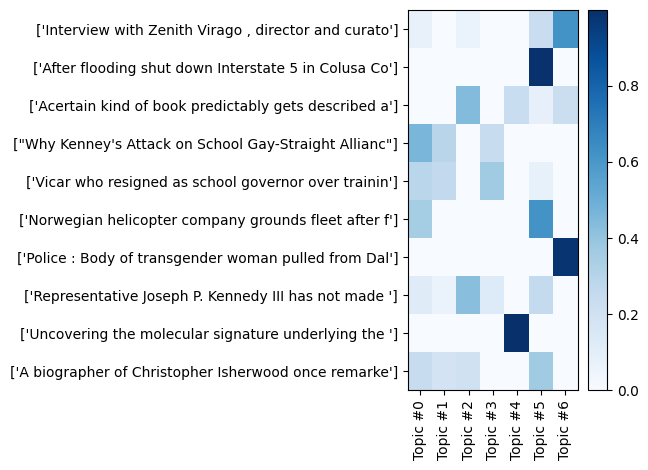

In [285]:
# Let's sample + visualize 10 or so documents.

ldaDF['title'] = ldaDF['text'].apply(lambda x: x.strip()[:50])

ldaDFV = ldaDF[:10][[f'topic_{i}' for i in range(num_topics)]]
ldaDFVisT = ldaDF[:10][['title']]
ldaDFVis = ldaDFV.values
ldaDFVisTitles = ldaDFVisT.values

# And we visualize via heat map, as stacked bar plots are gross.

topic_labels = [f'Topic #{k}' for k in range(num_topics)]

plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisTitles);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [286]:
topics_dict = {}
for i in range(num_topics):
    topicWords = [w for w, _ in translda.show_topic(i)]
    topics_dict[f'Topic_{i}'] = topicWords

wordranks = pandas.DataFrame(topics_dict)
wordranks

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,say,film,like,say,like,say,woman
1,people,say,white,gender,new,like,say
2,gay,people,trump,health,look,fashion,man
3,pride,church,say,transgender,food,work,sex
4,community,award,people,sex,say,year,people
5,right,good,know,sexual,time,time,female
6,come,year,right,court,think,look,year
7,year,sex,national,people,high,people,police
8,support,new,think,right,thing,new,new
9,parade,right,time,government,body,story,like


In [289]:
ldaDF.iloc[1].get('text')

'   After flooding shut down Interstate 5 in Colusa County for more than five hours , officials reopened the roadway Thursday . Southbound lanes of I-5 were closed around 10:30 a.m. between Maxwell Road and Highway 20 , near the community of Williams , Caltrans said . A nearby waterway flooded , spilling onto the highway and making it impassable . Some drivers sat in traffic for hours . " It was supposed to be a two-hour drive , " said Taimur Khan , who was heading to Sacramento . " So far , I\'m on hour 3-and-a-half . " Officials diverted traffic for a short time , leading drivers off the highway at Maxwell Road and into the city of Colusa.Around 3:45 p.m. , officials reopened the roadway as the water began to recede . Caltrans said there is heavy congestion in the area due to a 7-mile traffic backup . One lane remained close for sometime but has since reopened . " I just want to get where I\'m going , " said Bob Volpi , who was heading to Sonora . Volip pulled off the interstate , op

This adds continued evidence to the need to add "say" as a stopword in future analysis...

Regardless, based on the above, our topics appear to be:
* Topic 0: Controversy over the pride parade.
* Topic 1: Controversy over media.
* Topic 2: Trump's national policy, and Trumpism.
* Topic 3: Trangender rights and health.
* Topic 4: New discoveries; our example document from the heat map has to do with plants.
* Topic 5: Transport, fashion, and jobs.
* Topic 6: Police, death, and women.

Suffice it to say, these topics are.. not clearly distinguished. The tokens in each topic have heavy overlap, and aren't very useful tokens overall. 

Although not captured here, the above topic choice of 7 was chosen after fiddling with the topic number parameter to find topics that were relatively well differentiated -- my initial number was 10, and then I went down to 7 after fiddling. The choice of alpha was best when using the automatically generated option, while a generally high eta forced the topics to be more separated than other options.

Generally, these topics reveal that I would need to do much more subsetting to make these articles viable for further analysis; as stands, the breadth of topics discussed in these articles makes it challenging to characterize the corpus as "trans articles."



## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

None of the datasets relevant to my final project are good candidates for dynamic topic models (due to a mixture of lack of length and lack of timestamps). As such, I'm going to attmept to attempt to use the coha_genres dictionary to conduct analysis on topic evolution for the magazine genre.

In [297]:
coha_mag_years = {}
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if not genre == "mag":
        continue

    if year not in coha_mag_years:
        coha_mag_years[year] = []
    if year in coha_mag_years:
        coha_mag_years[year].append(coha_texts[article])

coha_mag_years.keys()

dict_keys(['1815', '1816', '1817', '1818', '1819', '1820', '1821', '1822', '1823', '1824', '1825', '1826', '1827', '1828', '1829', '1830', '1831', '1832', '1833', '1834', '1835', '1836', '1837', '1838', '1839', '1840', '1841', '1842', '1843', '1844', '1845', '1846', '1847', '1848', '1849', '1850', '1851', '1852', '1853', '1854', '1855', '1856', '1857', '1858', '1859', '1860', '1861', '1862', '1863', '1864', '1865', '1866', '1867', '1868', '1869', '1870', '1871', '1872', '1873', '1874', '1875', '1876', '1877', '1878', '1879', '1880', '1881', '1882', '1883', '1884', '1885', '1886', '1887', '1888', '1889', '1890', '1891', '1892', '1893', '1894', '1895', '1896', '1897', '1898', '1899', '1900', '1901', '1902', '1903', '1904', '1905', '1906', '1907', '1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

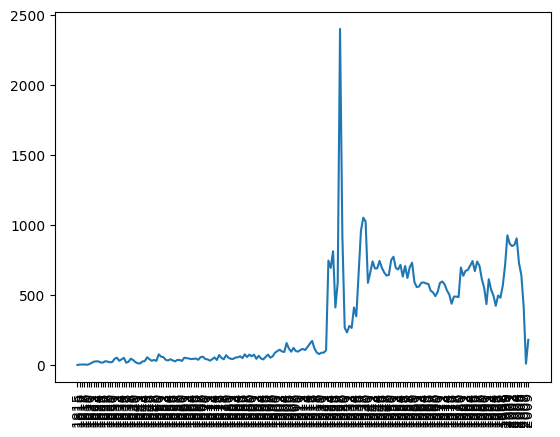

In [357]:
import matplotlib.pyplot as plt
import collections

years, year_lens = [], []

for year_info in collections.OrderedDict(sorted(coha_mag_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_mag_years[year_info])))

plt.plot(years, year_lens)
plt.xticks(rotation=90)

This plot is aggressively not legible, but the trends in it are still visible. Notably, we have a massive peak about halfway through our timespan, and the beginning of our timespan has relatively minimal publication amounts.

We probably want that peak to get captured in its own bin, which means we should use an odd number of bins. 5 seems reasonable -- let's graph and see what that looks like.

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

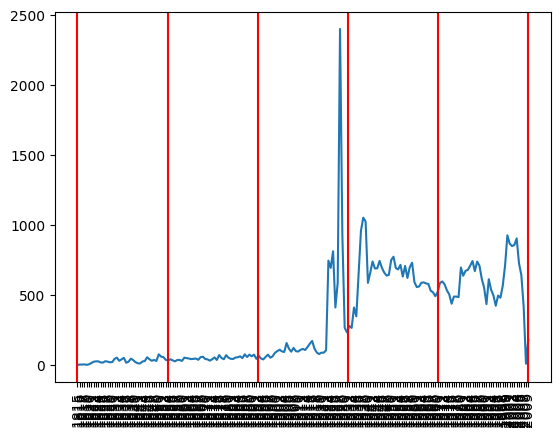

In [325]:
bars = np.linspace(0, 194, 6)

plt.plot(years, year_lens)
for bar in bars:
    plt.axvline(x=bar, color='red')
plt.xticks(rotation=90)


Ah, five bins actually cuts it. 4 should work?

[  0.   48.5  97.  145.5 194. ]


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

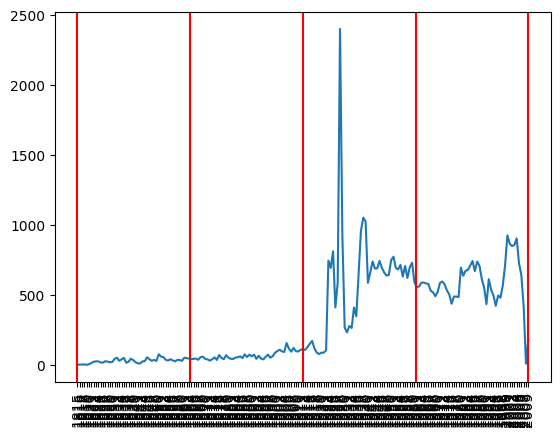

In [326]:
bars = np.linspace(0, 194, 5)
print(bars)
plt.plot(years, year_lens)
for bar in bars:
    plt.axvline(x=bar, color='red')
plt.xticks(rotation=90)

4 bins looks good! Now to make the topic model. The following code takes a frankly concerning amount of time to run, so we refuse to ever rerun it.

In [328]:
mag_text_coha = []
docs_per_timeslice = [0, 0, 0, 0]
i = 0

for year_info in collections.OrderedDict(sorted(coha_mag_years.items())):
    large_files = 0
    for article in coha_mag_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                mag_text_coha.append(lucem_illud.normalizeTokens(article[2].decode('utf-8')))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    if i < 48.5:
        docs_per_timeslice[0] += len(coha_mag_years[year_info]) - large_files
    if i >= 48.5 and i < 97:
        docs_per_timeslice[1] += len(coha_mag_years[year_info]) - large_files
    if i >= 97 and i < 145:
        docs_per_timeslice[2] += len(coha_mag_years[year_info]) - large_files
    if i >= 145:
        docs_per_timeslice[3] += len(coha_mag_years[year_info]) - large_files
    i += 1


C:\Users\wimer\AppData\Roaming\Python\Python311\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [330]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

As per the larger analyis, I'm shrinking and splitting the corpus.

In [358]:
corpus_size = 100 # initially i tried this at 250, but that took too long.
smaller = choose_n(mag_text_coha, docs_per_timeslice, nums=corpus_size)

In [343]:
final_corpus = []
# subtle changes make all the diff 
docs_per_time_slice = [0, 0, 0, 0] 

In [344]:
for i, article in enumerate(smaller):
    # identify time slice based on article number    
    if i < corpus_size: time = 0
    if i >= corpus_size and i < corpus_size * 2: time = 1
    if i >= corpus_size * 2 and i < corpus_size * 3: time = 2
    if i >= corpus_size * 3: time = 3

    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

And now we make the model.

In [345]:
dictionary = gensim.corpora.Dictionary(final_corpus)
corpus = [dictionary.doc2bow(text) for text in final_corpus]
gensim.corpora.MmCorpus.serialize('cohamag.mm', corpus)
cohamagcorpus = gensim.corpora.MmCorpus('cohamag.mm')

In [346]:
from gensim.models import ldaseqmodel

ldaseq = ldaseqmodel.LdaSeqModel(corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)
ldaseq.save('coha_mag_ldaseqmodel')

C:\Users\wimer\AppData\Roaming\Python\Python311\site-packages\gensim\models\ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)


In [356]:
topicsDict = {}
for topic in range(4):
    for time in range(4):
        # this should be a list of word, _ parirs
        topicWords = [w for w, _ in ldaseq.print_topics(time=time)[topic]]
        topicsDict[f'Topic_{topic}.{time}'] = topicWords
    
wordsDF = pandas.DataFrame(topicsDict)
wordsDF

,Topic_0.0,Topic_0.1,Topic_0.2,Topic_0.3,Topic_1.0,Topic_1.1,Topic_1.2,Topic_1.3,Topic_2.0,Topic_2.1,Topic_2.2,Topic_2.3,Topic_3.0,Topic_3.1,Topic_3.2,Topic_3.3
0,time,little,little,>,great,great,man,man,states,government,states,states,general,general,general,general
1,little,time,day,little,man,man,great,great,government,states,government,government,army,army,grant,grant
2,like,day,time,time,life,life,life,life,state,state,state,public,grant,grant,army,army
3,man,like,like,day,men,men,men,men,public,people,public,state,time,war,war,war
4,day,man,man,like,world,world,world,world,great,public,people,new,war,time,time,time
5,old,old,old,man,nature,nature,work,work,new,new,new,great,mr,men,men,men
6,said,said,life,old,work,mind,nature,new,law,great,great,law,men,mr,enemy,enemy
7,long,life,said,said,mind,work,mind,mind,people,law,law,people,country,enemy,mr,mr
8,came,came,came,came,new,new,new,nature,country,power,country,country,enemy,country,country,country
9,great,long,long,long,time,character,time,time,mr,country,power,power,great,great,troops,troops


This topic analysis reflects four astonishingly (potentially _concerningly_) stable topics across our time frame. The topics seem to be something like:
* Topic 0.x: Grounded narratives of life and people
* Topic 1.x: Scholarly pursuits with an emphasis on people
* Topic 2.x: Political discussion
* Topic 3.x: Military and war discussion

Most of these topics are, as stated about, _very_ stable. Topic 0, 1, and 3 for instance, hardly change their representative tokens. A notable exception to that trend is that Topic 0 does seem to gain `<` `>` as tokens; the COHA dataset does have web articles within it, some of which are more akin to blog-esque articles, so it's possible that these came from web article tags and are representative of that topic shifting towards the digital realm. Nonetheless, Topic 1 and 3 do not appear to have an large shifts, beyond perhaps the steady decrease in "nature" as a prominent word in topic 3. Topic 2 interestingly has "england" fall out of prominence after the first two time splits, which is maybe representative of both changes in terminology -- with a shift from calling it "england" to "the UK" -- and the decrease in England's international importance. 